## Statoil / C-CORE Iceberg Recognition (Kaggle)

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import json
import os
import keras
import time

from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Concatenate, concatenate, Input, Dropout
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Reading data and preprocessing

In [2]:
def read_data(data_path):
    raw_data = pd.read_json(data_path)
    raw_data = raw_data.replace('na', np.nan)    
    raw_data.index = raw_data['id']
    raw_data = raw_data.drop('id', axis=1)
    raw_data = raw_data.fillna(raw_data['inc_angle'].mean()) 
    raw_data['inc_angle_pi'] = raw_data['inc_angle'].values / 365 * 2 * np.pi
    return raw_data

def construct_rgb(df):        
    images = []    
    for i, row in df.iterrows():        
        band_1 = np.array(row['band_1']).reshape(75,75)
        band_2 = np.array(row['band_2']).reshape(75,75)
        band_3 = band_1 + band_2
        
        band_1_norm = (band_1 - band_1.mean()) / (band_1.max() - band_1.min())
        band_2_norm = (band_2 - band_2.mean()) / (band_2.max() - band_2.min())
        band_3_norm = (band_3 - band_3.mean()) / (band_3.max() - band_3.min())        
        
        images.append(np.dstack((band_1_norm, band_2_norm, band_3_norm)))             
    return np.array(images)

def image_resize(image, img_size):    
    image_new = np.zeros((image.shape[0], img_size, img_size, image.shape[3]))                         
    for i in range(image.shape[0]):
        image_new[i]=cv2.resize(image[i],(img_size, img_size), interpolation = cv2.INTER_LINEAR)    
    return image_new

def image_laplacian(image, kernel):    
    image_new = np.zeros_like(image)                        
    for i in range(image.shape[0]):
        image_new[i]=cv2.Laplacian(image[i], cv2.CV_32F, ksize=kernel)  
    return image_new

def plot_rand(image_data,plot_type = 'default', kernel = 7, sigma = 10, laplacian_kernel = 7):
    
    np.random.seed(60)   
    random_idx = np.random.choice(range(image_data.shape[0]), 36)
    
    plt.figure(figsize=(20,120))
    plt.subplot(36, 6, 6)    
    
    for i in range(36):                
        plt.subplot(36, 6, i+1)
        if plot_type=='laplacian':
            plt.imshow(cv2.Laplacian(image_data[random_idx[i], :, :, :], cv2.CV_32F, ksize=kernel), cmap='viridis')          
        elif plot_type=='gaussian':
            plt.imshow(cv2.bilateralFilter(image_data[random_idx[i], :, :, :], kernel, sigma, sigma), cmap='viridis')
        elif plot_type=='gaussian_laplacian':
            plt.imshow(cv2.bilateralFilter(cv2.Laplacian(image_data[random_idx[i], :, :, :], cv2.CV_32F, ksize=laplacian_kernel), kernel, sigma, sigma), cmap='viridis')
        else:
            plt.imshow(image_data[random_idx[i], :, :, :])

        plt.axis('off')
        plt.title("Image" + str(random_idx[i]) + "/" + str(is_iceberg[random_idx[i]]))
    plt.show() 
    
def prediction_model(file_path, X_test):
    model = keras.models.load_model(file_path)    
    y = model.predict(X_test)
    return y

In [3]:
TRAIN_DATA_PATH = './Data/train.json'
TEST_DATA_PATH = './Data/test.json'
IMG_SIZE = 150
img_size = 150
NUM_BAND = 3
EPOCH = 50

In [4]:
train_data = read_data(TRAIN_DATA_PATH)
test_data = read_data(TEST_DATA_PATH)
X_train = construct_rgb(train_data)
X_train = image_resize(X_train, IMG_SIZE)

is_iceberg = train_data['is_iceberg'].values
y_train= np.asarray(pd.get_dummies(is_iceberg, sparse=False))
X_test = construct_rgb(test_data)
X_test = image_resize(X_test, IMG_SIZE)

In [5]:
y_train = y_train[:, 1]

## Building Convolutional Neural Net

In [6]:
def model_1():     
    
    base_model= Xception(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_size, img_size, NUM_BAND), pooling=None, classes=1000) 
    x = base_model.output 
    x = BatchNormalization()(x)
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(512, activation='relu')(x)   
    x = Dropout(0.50)(x)
    
    pred = Dense(1, activation='sigmoid')(x)    
    model = Model(inputs = base_model.input, outputs = pred)
    
    return model

In [7]:
def model_2():     
    
    base_model= InceptionV3(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_size, img_size, NUM_BAND), pooling=None, classes=1000) 
    x = base_model.output
    x = BatchNormalization()(x)
    x = GlobalMaxPooling2D()(x)
    
    
    x = Dense(512, activation='relu')(x)     
    x = Dropout(0.50)(x)    
        
    pred = Dense(1, activation='sigmoid')(x)    
    model = Model(inputs = base_model.input, outputs = pred)
    
    return model

In [8]:
def model_3():     
    
    base_model= InceptionResNetV2(include_top=False, weights='imagenet', input_tensor=None, input_shape=(img_size, img_size, NUM_BAND), pooling=None, classes=1000) 
    x = base_model.output
    x = BatchNormalization()(x)
    x = GlobalMaxPooling2D()(x)
    
    
    x = Dense(512, activation='relu')(x)     
    x = Dropout(0.50)(x)    
        
    pred = Dense(1, activation='sigmoid')(x)    
    model = Model(inputs = base_model.input, outputs = pred)
    
    return model

In [9]:
def train(model, X_train, y_train, X_valid, y_valid, trainable_layers, epochs, callback, augment, filename):

    #print(len(model.layers))
#     for layer in model.layers[:trainable_layers]:
#         layer.trainable = False
#     for layer in model.layers[trainable_layers:]:
#         layer.trainable = True   
    
    verbose = 2
        
    optimizer=keras.optimizers.Nadam(lr=0.00025)            

    if callback:    
        callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_acc', patience=15, verbose=1),
                          keras.callbacks.ModelCheckpoint('./Callbacks/' + filename +'.hd5f', 
                                                          monitor='val_acc', verbose=0, 
                                                          save_best_only=True, save_weights_only=False, 
                                                          mode='auto', period=1)]
        callbacks_list = [keras.callbacks.ModelCheckpoint('./Callbacks/' + filename +'.hd5f', 
                                                          monitor='val_acc', verbose=0, 
                                                          save_best_only=True, save_weights_only=False, 
                                                          mode='auto', period=1)]
        
        
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    if augment:
        datagen = ImageDataGenerator(horizontal_flip = True,
                             vertical_flip = True,
                             width_shift_range = 0.20,
                             height_shift_range = 0.20,
                             zoom_range = 0.20,
                             rotation_range = 30)        

        history = model.fit_generator(datagen.flow(X_train,y_train), len(X_train)/8, epochs=epochs, verbose=verbose, 
                                      callbacks=callbacks_list, validation_data=datagen.flow(X_valid,y_valid),
                                      validation_steps = len(X_valid)/8, shuffle=True, initial_epoch=0)
    else:
        history = model.fit(X_train, y_train, 
                            epochs=epochs, validation_data=(X_valid, y_valid), verbose=verbose, callbacks=callbacks_list)

    plt.figure(figsize=(20,10))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model Accuracy', fontsize = 15)
    plt.ylabel('Accuracy', fontsize = 15)
    plt.xlabel('Epoch', fontsize = 15)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 15)

    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss', fontsize = 15)
    plt.ylabel('Loss', fontsize = 15)
    plt.xlabel('Epoch', fontsize = 15)
    plt.legend(['Train', 'Test'], loc='upper left', fontsize = 15)
    plt.show()

Model 2
Train on 1336 samples, validate on 268 samples
Epoch 1/50
 - 24s - loss: 0.8792 - acc: 0.7178 - val_loss: 0.5845 - val_acc: 0.7873
Epoch 2/50
 - 5s - loss: 0.3558 - acc: 0.8630 - val_loss: 0.5549 - val_acc: 0.8321
Epoch 3/50
 - 5s - loss: 0.2467 - acc: 0.9079 - val_loss: 0.3833 - val_acc: 0.8582
Epoch 4/50
 - 5s - loss: 0.0893 - acc: 0.9626 - val_loss: 0.5462 - val_acc: 0.8582
Epoch 5/50
 - 5s - loss: 0.0521 - acc: 0.9843 - val_loss: 0.5272 - val_acc: 0.8694
Epoch 6/50
 - 5s - loss: 0.0304 - acc: 0.9880 - val_loss: 0.8167 - val_acc: 0.8396
Epoch 7/50
 - 5s - loss: 0.0442 - acc: 0.9850 - val_loss: 0.6987 - val_acc: 0.8657
Epoch 8/50
 - 5s - loss: 0.0383 - acc: 0.9843 - val_loss: 0.9396 - val_acc: 0.8582
Epoch 9/50
 - 5s - loss: 0.0449 - acc: 0.9798 - val_loss: 0.7419 - val_acc: 0.8582
Epoch 10/50
 - 5s - loss: 0.0537 - acc: 0.9813 - val_loss: 0.6833 - val_acc: 0.8731
Epoch 11/50
 - 5s - loss: 0.0795 - acc: 0.9775 - val_loss: 0.6019 - val_acc: 0.8881
Epoch 12/50
 - 5s - loss: 0.0

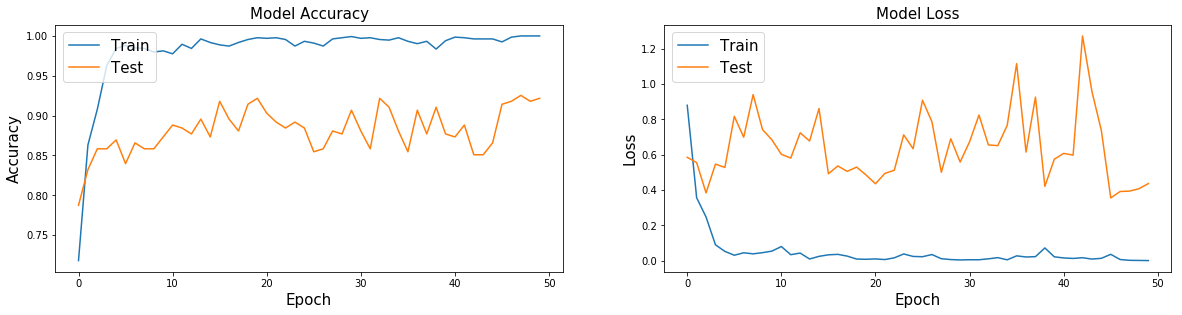

Model 2
Train on 1336 samples, validate on 268 samples
Epoch 1/50
 - 41s - loss: 0.7770 - acc: 0.7073 - val_loss: 0.5872 - val_acc: 0.8097
Epoch 2/50
 - 5s - loss: 0.2735 - acc: 0.8915 - val_loss: 0.3907 - val_acc: 0.8582
Epoch 3/50
 - 5s - loss: 0.1604 - acc: 0.9506 - val_loss: 0.4273 - val_acc: 0.8507
Epoch 4/50
 - 5s - loss: 0.1032 - acc: 0.9723 - val_loss: 0.4576 - val_acc: 0.8657
Epoch 5/50
 - 5s - loss: 0.0423 - acc: 0.9873 - val_loss: 0.4828 - val_acc: 0.8694
Epoch 6/50
 - 5s - loss: 0.0163 - acc: 0.9925 - val_loss: 0.5138 - val_acc: 0.8769
Epoch 7/50
 - 5s - loss: 0.0215 - acc: 0.9925 - val_loss: 0.6362 - val_acc: 0.8769
Epoch 8/50
 - 5s - loss: 0.0239 - acc: 0.9918 - val_loss: 0.5446 - val_acc: 0.8955
Epoch 9/50
 - 5s - loss: 0.0355 - acc: 0.9820 - val_loss: 0.5415 - val_acc: 0.8843
Epoch 10/50
 - 5s - loss: 0.0912 - acc: 0.9798 - val_loss: 0.6091 - val_acc: 0.8619
Epoch 11/50
 - 5s - loss: 0.0688 - acc: 0.9738 - val_loss: 0.6299 - val_acc: 0.8694
Epoch 12/50
 - 5s - loss: 0.0

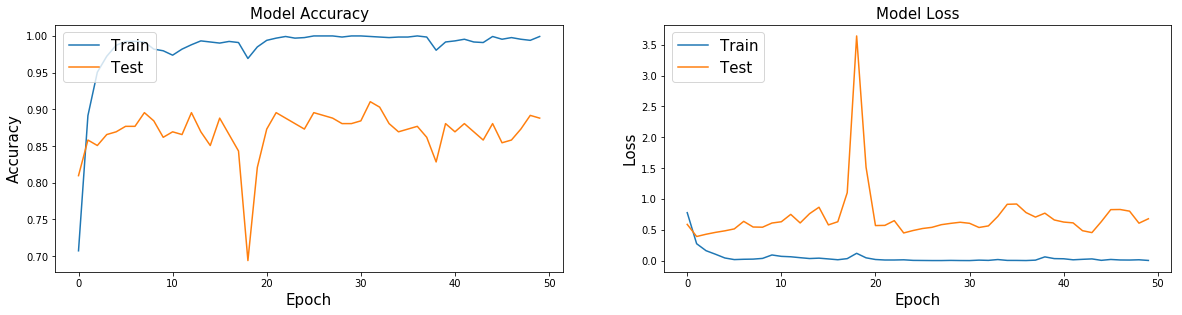

Model 2
Train on 1336 samples, validate on 268 samples
Epoch 1/50
 - 58s - loss: 0.7435 - acc: 0.7246 - val_loss: 0.5350 - val_acc: 0.7948
Epoch 2/50
 - 5s - loss: 0.3088 - acc: 0.8795 - val_loss: 0.4318 - val_acc: 0.8507
Epoch 3/50
 - 5s - loss: 0.1866 - acc: 0.9244 - val_loss: 0.4045 - val_acc: 0.8694
Epoch 4/50
 - 5s - loss: 0.1089 - acc: 0.9708 - val_loss: 0.4875 - val_acc: 0.8619
Epoch 5/50
 - 5s - loss: 0.0529 - acc: 0.9798 - val_loss: 0.6329 - val_acc: 0.8731
Epoch 6/50
 - 5s - loss: 0.0379 - acc: 0.9843 - val_loss: 0.5081 - val_acc: 0.8769
Epoch 7/50
 - 5s - loss: 0.0535 - acc: 0.9798 - val_loss: 0.6340 - val_acc: 0.8358
Epoch 8/50
 - 5s - loss: 0.0532 - acc: 0.9865 - val_loss: 0.5480 - val_acc: 0.8694
Epoch 9/50
 - 5s - loss: 0.0707 - acc: 0.9768 - val_loss: 0.6165 - val_acc: 0.8284
Epoch 10/50
 - 5s - loss: 0.0478 - acc: 0.9820 - val_loss: 0.5665 - val_acc: 0.8694
Epoch 11/50
 - 5s - loss: 0.0292 - acc: 0.9903 - val_loss: 0.6622 - val_acc: 0.8433
Epoch 12/50
 - 5s - loss: 0.0

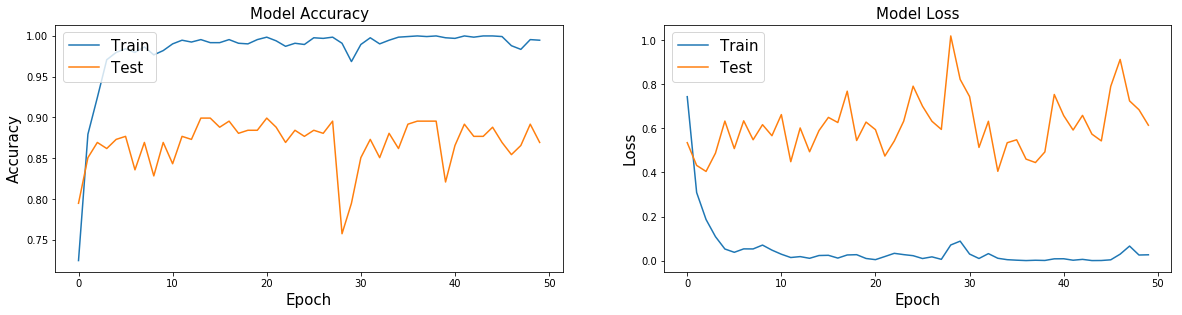

Model 2
Train on 1337 samples, validate on 267 samples
Epoch 1/50
 - 73s - loss: 0.7308 - acc: 0.7098 - val_loss: 0.9831 - val_acc: 0.8240
Epoch 2/50
 - 6s - loss: 0.3372 - acc: 0.8773 - val_loss: 0.3568 - val_acc: 0.8539
Epoch 3/50
 - 5s - loss: 0.1798 - acc: 0.9282 - val_loss: 0.4119 - val_acc: 0.8801
Epoch 4/50
 - 6s - loss: 0.0703 - acc: 0.9761 - val_loss: 0.6651 - val_acc: 0.8801
Epoch 5/50
 - 5s - loss: 0.0551 - acc: 0.9858 - val_loss: 0.5701 - val_acc: 0.8989
Epoch 6/50
 - 5s - loss: 0.0476 - acc: 0.9858 - val_loss: 0.5073 - val_acc: 0.8727
Epoch 7/50
 - 5s - loss: 0.0469 - acc: 0.9828 - val_loss: 0.5150 - val_acc: 0.8801
Epoch 8/50
 - 5s - loss: 0.0444 - acc: 0.9843 - val_loss: 0.4493 - val_acc: 0.8577
Epoch 9/50
 - 5s - loss: 0.0455 - acc: 0.9806 - val_loss: 0.6851 - val_acc: 0.8801
Epoch 10/50
 - 5s - loss: 0.0454 - acc: 0.9843 - val_loss: 0.7372 - val_acc: 0.8839
Epoch 11/50
 - 5s - loss: 0.0212 - acc: 0.9940 - val_loss: 0.7610 - val_acc: 0.8839
Epoch 12/50
 - 5s - loss: 0.0

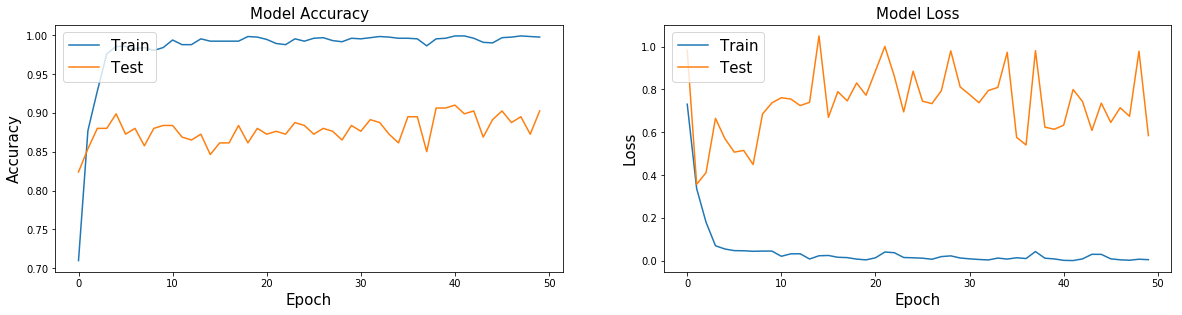

Model 2
Train on 1337 samples, validate on 267 samples
Epoch 1/50
 - 91s - loss: 0.8204 - acc: 0.7016 - val_loss: 0.6397 - val_acc: 0.8165
Epoch 2/50
 - 6s - loss: 0.3889 - acc: 0.8422 - val_loss: 0.4861 - val_acc: 0.8539
Epoch 3/50
 - 6s - loss: 0.1587 - acc: 0.9327 - val_loss: 0.5763 - val_acc: 0.8614
Epoch 4/50
 - 5s - loss: 0.1037 - acc: 0.9611 - val_loss: 0.4898 - val_acc: 0.8539
Epoch 5/50
 - 6s - loss: 0.0726 - acc: 0.9693 - val_loss: 0.5459 - val_acc: 0.8876
Epoch 6/50
 - 5s - loss: 0.0744 - acc: 0.9723 - val_loss: 0.4780 - val_acc: 0.8839
Epoch 7/50
 - 5s - loss: 0.0397 - acc: 0.9858 - val_loss: 0.9021 - val_acc: 0.8165
Epoch 8/50
 - 5s - loss: 0.0411 - acc: 0.9835 - val_loss: 0.7327 - val_acc: 0.8352
Epoch 9/50
 - 6s - loss: 0.0354 - acc: 0.9858 - val_loss: 0.4958 - val_acc: 0.8951
Epoch 10/50
 - 5s - loss: 0.0473 - acc: 0.9835 - val_loss: 0.3977 - val_acc: 0.8839
Epoch 11/50
 - 5s - loss: 0.0132 - acc: 0.9948 - val_loss: 0.5408 - val_acc: 0.8951
Epoch 12/50
 - 5s - loss: 0.0

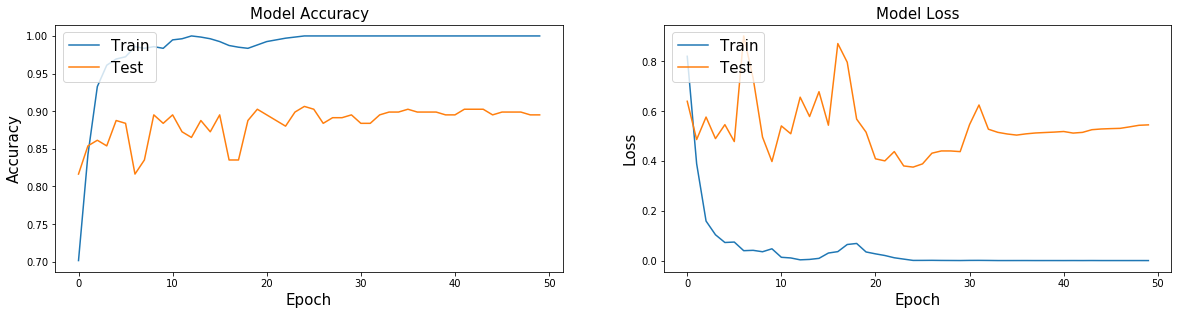

Model 2
Train on 1338 samples, validate on 266 samples
Epoch 1/50
 - 107s - loss: 0.8504 - acc: 0.7227 - val_loss: 2.5532 - val_acc: 0.6692
Epoch 2/50
 - 6s - loss: 0.3679 - acc: 0.8550 - val_loss: 0.5358 - val_acc: 0.7970
Epoch 3/50
 - 6s - loss: 0.1645 - acc: 0.9327 - val_loss: 0.4900 - val_acc: 0.8308
Epoch 4/50
 - 5s - loss: 0.0776 - acc: 0.9679 - val_loss: 0.9251 - val_acc: 0.7970
Epoch 5/50
 - 5s - loss: 0.0910 - acc: 0.9709 - val_loss: 0.8427 - val_acc: 0.7782
Epoch 6/50
 - 5s - loss: 0.0674 - acc: 0.9768 - val_loss: 0.6467 - val_acc: 0.8158
Epoch 7/50
 - 5s - loss: 0.0289 - acc: 0.9865 - val_loss: 1.0874 - val_acc: 0.7707
Epoch 8/50
 - 5s - loss: 0.0374 - acc: 0.9851 - val_loss: 0.6992 - val_acc: 0.8271
Epoch 9/50
 - 6s - loss: 0.0352 - acc: 0.9873 - val_loss: 0.5137 - val_acc: 0.8534
Epoch 10/50
 - 5s - loss: 0.0248 - acc: 0.9933 - val_loss: 0.7916 - val_acc: 0.8421
Epoch 11/50
 - 5s - loss: 0.0342 - acc: 0.9888 - val_loss: 1.0559 - val_acc: 0.8195
Epoch 12/50
 - 6s - loss: 0.

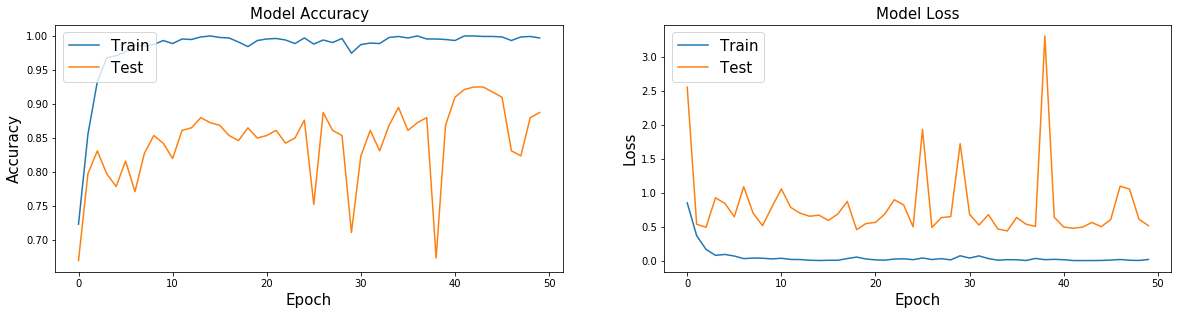

In [10]:
n_kfold = 6
kfold= StratifiedKFold(n_splits = n_kfold).split(X_train, y_train)    


for k, (train_idx, test_idx) in enumerate(kfold):    
    X_train_kfold = X_train[train_idx, :, :, :]
    y_train_kfold = y_train[train_idx]
    X_valid_kfold = X_train[test_idx, :, :, :]
    y_valid_kfold = y_train[test_idx]    
    
#     print('Model 1')
#     CNN_model_1a = model_1()    
#     train(CNN_model_1a, X_train_kfold, y_train_kfold, X_valid_kfold, y_valid_kfold, 
#           1500, EPOCH, True, False, 'params_1a' + str(k))
    
#     CNN_model_1b = model_1()    
#     train(CNN_model_1b, X_train_kfold, y_train_kfold, X_valid_kfold, y_valid_kfold, 
#           1500, EPOCH, True, True, 'params_1b' + str(k))   
    
    print('Model 2')
    CNN_model_2a = model_2()
    train(CNN_model_2a, X_train_kfold, y_train_kfold, X_valid_kfold, y_valid_kfold, 
          30, EPOCH, True, False, 'params_2a' + str(k)) 
    
#     CNN_model_2b = model_2()
#     train(CNN_model_2b, X_train_kfold, y_train_kfold, X_valid_kfold, y_valid_kfold, 
#           30, EPOCH, True, True, 'params_2b' + str(k)) 
    
#     print('Model 3')
#     CNN_model_3a = model_3()
#     train(CNN_model_3a, X_train_kfold, y_train_kfold, X_valid_kfold, y_valid_kfold, 
#           30, EPOCH, True, False, 'params_3a' + str(k)) 
    
#     CNN_model_3b = model_3()
#     train(CNN_model_3b, X_train_kfold, y_train_kfold, X_valid_kfold, y_valid_kfold, 
#           30, EPOCH, True, True, 'params_3b' + str(k)) 



In [11]:
y_pred_final = np.zeros((X_test.shape[0], 1))
for k in range(6):        
    y_pred = np.zeros((X_test.shape[0], 1))
    y_pred = prediction_model('./Callbacks/params_2a'+ str(k) + '.hd5f', X_test) 
    y_pred_final += y_pred

y_pred_final /=  6

In [12]:
# y_pred_final = np.zeros((X_test.shape[0], 1))
# for i in range(3):
#     for j, k in enumerate(['a', 'b']):        
#         y_pred = np.zeros((X_test.shape[0], 1))
#         y_pred = prediction_model('./Callbacks/params_'+ str(j+1) + k + str(i) + '.hd5f', X_test) 
#         y_pred_final += y_pred

# y_pred_final /=  10

## Prediction

In [13]:
y_pred_final

array([[8.05417359e-03],
       [2.15077639e-01],
       [1.12329026e-05],
       ...,
       [1.42210434e-01],
       [9.99999603e-01],
       [5.30493664e-05]])

In [14]:
submission = pd.DataFrame(y_pred_final, index=test_data.index, columns = ['is_iceberg']) 
submission.to_csv('./Submission/submission.csv')
submission

,is_iceberg
id,
5941774d,8.054174e-03
4023181e,2.150776e-01
b20200e4,1.123290e-05
e7f018bb,9.998702e-01
4371c8c3,1.131867e-01
a8d9b1fd,2.839785e-02
29e7727e,8.779620e-05
92a51ffb,9.999992e-01
c769ac97,1.210350e-06
